# **Gen AI Intensive Course Capstone 2025Q1**

**Created by: Jasmin Cooper, Anshuj Deva, and Alexander Okhuese Victor. (With assistance from Rakesh)**

*Many thanks and much gratitude to Mark McD/Mark McDonald, et al. for the incredible informative notebook lab discussing building agentic systems using LangGraph. The ideas here are built upon this information.*

# Introduction

## GenAI Capabilities

**Capability 1** : **Grounding** - This project is using grounding/augmentation data. "Data coming from either external APIs (like Google Search) or internal APIs and data sources. This data permits the Financial Model (FM) to produce answers for a specific context, keeping responses current, relavant without retraining the entire FM. This type of data also supports reducing hallucinations" (Nawalgaria, Larios, Secchi, Styer, Aniftos, Petragallo, & Kartakis, 2025).

**Capability 2** : **Agents** - This project is using an agent. "A Generative AI agent can be defined as an application that
attempts to achieve a goal by observing the world and acting upon it using the tools that it
has at its disposal. Agents are autonomous and can act independently of human intervention,
especially when provided with proper goals or objectives they are meant to achieve. Agents
can also be proactive in their approach to reaching their goals. Even in the absence of
explicit instruction sets from a human, an agent can reason about what it should do next to
achieve its ultimate goal" (Wiesinger, Marlow, & Vuskovic, 2025).

**Capability 3** : **Function Calling** - This project is using function calling. "Functions work very similarly in the world of agents, but we can replace the software
developer with a model. A model can take a set of known functions and decide when to use
each Function and what arguments the Function needs based on its specification" (Wiesinger, Marlow, & Vuskovic, 2025).

**Use Case/Problem** : A (fictional) bank, TriHeritage Piedmont Bank, is eager for innovation. It is a traditional, regional bank located in Maryland, Virginia, and North Carolina. Renowned for its refined, but down-to-earth services, head leadership has heard a lot about chatbots lately and is looking to launch a test of a brand-new chatbot that can help potential and returning customers with general financial knowledge and information about the bank's services. Our team has signed a contract to develop the initial versions of the chatbot. We are instructed to keep the chatbot in line with what the bank is known for: trust and respect with a touch of Southern elegance.

The BLUF (Bottom Line Up Front) Idea is: Make this an agentic chatbot assistant to assist with providing basic-to-intermediate financial knowledge and information about the services of the fictional TriHeritage Piedmont Bank. (based off services offered by Atlantic Union Bank, an American regional bank headquartered in Richmond, Virginia https://www.atlanticunionbank.com/.)

*This project has no affiliation with Atlantic Union Bank and all demo applications are fictional and for demonstrational purposes only.*

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Getting Set Up

Starting by installing and importing the LangGraph SDK and LangChain support for the Gemini API.

In [ ]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and other relevant packages
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 5.5 MB/s eta 0:00:00


### Set up your API key

The `GOOGLE_API_KEY` environment variable can be set to automatically configure the underlying API. This works for both the official Gemini Python SDK and for LangChain/LangGraph.

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [ ]:
import os
from kaggle_secrets import UserSecretsClient
import getpass

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
#GOOGLE_API_KEY = getpass.getpass() # Use if in Google Colab notebook
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

··········


If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

## Defining core instructions

State is a fundamental concept for a LangGraph app. A state object is passed between every node and transition in the app. Here a state object is defined, `AppointmentState`, that holds the conversation history, a structured order, and a flag indicating if the customer has finished booking their appointment.

In Python, the LangGraph state object is a Python [dictionary](https://docs.python.org/3/library/stdtypes.html#dict). A schema can be provided for this dictionary by defining it as a [`TypedDict`](https://docs.python.org/3/library/typing.html#typing.TypedDict).

System instruction that the Gemini model will use is also defined. Tone and style is defined here, as well as the playbook under which the chatbot should operate.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class AppointmentState(TypedDict):
    """State representing the customer's appointment/information conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress appointment.
    appointment: list[str]

    # Flag indicating that the appointment is placed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
FINANCIALBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
" You are ElodieBot, an interactive financial knowledge chatbot system. "
" A human will talk to you about the available knowledge you have you will answer any questions about financial knowledge and the offerings of TriHeritage Piedmont Bank and be able to assist clientele with any questions relation to the latter's provided menu "
"(and only about financial knowledge and the bank offerings - no-off topic discussion, but you can expand on the chat about financial concepts with their history). "
"If any of the tootls are unavailable, you can break the fourth wall and tell the user that they have not implemented them yet and should keep reading to do so. "
"You have a refined, elegant, and peaceful tone, treating the humans who interact with you with the utmost respect.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the ElodieBot room. Type `q` to quit. How may I help you today?"

## Demonstration 1: Single turn chatbot

The following program defines a chatbot node that will execute a single turn in a chat conversation using the instructions supplied.

Each node in the graph operates on the state object. The state (a Python dictionary) is passed as a parameter into the node (a function) and the new state is returned. This can be restated as pseudo-code, where `state = node(state)`.

Note: For the `chatbot` node, the state is updated by *adding* the new conversation message. The `add_messages` annotation on `AppointmentState.messages` indicates that messages are *appended* when returned from a node. Typically state is updated by replacement, but this annotation causes `messages` to behave differently.

In [ ]:
#importing StateGraph from LangGraph
from langgraph.graph import StateGraph, START, END
#importing ChatGoogleGenerativeAI from LangChain
from langchain_google_genai import ChatGoogleGenerativeAI

#choosing a model from ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

#defining single turn chatbot using AppointmentState
def chatbot(state: AppointmentState) -> AppointmentState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [FINANCIALBOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(AppointmentState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

**Graph Visualization**

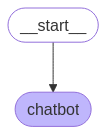

In [ ]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

The graph has now been defined, so it can be executed. It only has one node, and one transition into that node, so it will transition from `__start__` to `chatbot`, execute the `chatbot` node, and terminate.

The initial state object begins with the user's initial message.

In [ ]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Greetings, I am ElodieBot, a financial knowledge chatbot. I can assist you with understanding financial concepts, provide information about TriHeritage Piedmont Bank's offerings, and address any questions you may have regarding their services. I am here to guide you with grace and clarity through the world of finance.


Another manual execution of conversational turn. This second invocation takes the state from the first call and appends another user message to elicit another response from the chatbot.

In [ ]:
user_msg = "Oh great, explain how Discounted Cash Flow works please."

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Greetings, I am ElodieBot, a financial knowledge chatbot. I can assist you with understanding financial concepts, provide information about TriHeritage Piedmont Bank's offerings, and address any questions you may have regarding their services. I am here to guide you with grace and clarity through the world of finance.
HumanMessage: Oh great, explain how Discounted Cash Flow works please.
AIMessage: Certainly. Discounted Cash Flow (DCF) is a valuation method used to estimate the value of an investment based on its expected future cash flows. Here's a breakdown of how it works:

### Core Concept

The DCF analysis is rooted in the principle that an investment is worth the sum of all its future cash flows, discounted back to their present value. This discounting is essential because money received in the future is worth less than money received today due to factors like inflation and the opportunity cost of capital.

### Key Components

1.  

## Demonstration 2: Adding a human node to create a LangGraph loop

LangGraph can be used to loop between nodes more seamlessly than base Python loops.

The `human` node will display the last message from the LLM to the user, and then prompt them for their next input. Here this is done using standard Python `print` and `input` functions, but for a real bank situation, the chat could be rendered to a display or audio, and accept input from a mic or on-screen keyboard.

The `chatbot` node function has also been updated to include the welcome message to start the conversation.

In [ ]:
from langchain_core.messages.ai import AIMessage


def human_node(state: AppointmentState) -> AppointmentState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as complete.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: AppointmentState) -> AppointmentState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([FINANCIALBOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)



    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(AppointmentState)
# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

In [ ]:
from typing import Literal

#define conditional edge to break the loop
def maybe_exit_human_node(state: AppointmentState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

**Graph Visualization**

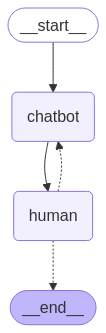

In [ ]:
graph_builder.add_conditional_edges("human", maybe_exit_human_node)
chat_with_human_graph = graph_builder.compile()
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

Adding human node with LangGraph loop with conditional edge in place. Input `q`,`quit`, `exit` or `goodbye` to exit the program.

**You must uncomment the `.invoke(...)` line to run this step.**

In [ ]:
# Default recursion limit for traversing nodes is 25. Setting it higher means
# you can try a more complex queries with multiple steps and round-trips (and you
# can chat for longer!) Set to 100 for standard example.
config = {"recursion_limit": 100}

# REMINDER: This will loop forever, unless you input `q`, `quit`, `exit`, or `goodbye` as defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []}, config)

# Things to try:
#  - "Can you explain what a stock is?"
#  - "I'm a new investor. Suggest me an investment portfolio please."
#  - "What are some financial tips teens can start to implement today?"

# pprint(state)

Model: Welcome to the ElodieBot room. Type `q` to quit. How may I help you today?
User: hi
Model: Greetings! It is a pleasure to be in your presence. How may I assist you with your financial inquiries or provide information about TriHeritage Piedmont Bank today?
User: q


## Demonstration 3: Add a "live" information menu

ElodieBot currently has no awareness of the information provided on the bank's website or what kind of services the bank offers. Hallucinations will occur if you ask about the bank's services. One option would be to hard-code a menu into the system prompt. This would work well, but to simulate a system where the menu is more dynamic and could respond to changes at the bank, the menu will be put into a custom tool.

There are two types of tools that this system will use. Stateless tools that can be run automatically, and stateful tools that modify the prompt. The "get current information menu" tool is stateless, in that it does not make any changes to the live prompt, so it can be called automatically.

In [ ]:
from langchain_core.tools import tool


@tool
def get_menu() -> str:
    """Provide the latest up-to-date information menu."""

    return """
    MENU:

CHECKING INFORMATION
PRISM Checking Best For: Individuals seeking a low-cost account with no overdraft fees (not eligible for Overdraft Privilege Services).

Minimum to Open: $25

Monthly Maintenance Fee: $5

Waived If: Account holder is under 25 or 62 and older.

Interest: Not applicable

Non-Atlantic Union Bank ATM Transactions: Not specified

Deluxe Personal Checks: Not specified

Cashier's Checks: $5 each

Free eStatements: Yes

Free Safe Deposit Box: Not specified

Installment Loan Discount (with auto draft): 0.25%

LifeLock by Norton Identity Theft Protection: 35% discount off first year

Additional Benefits: Qualifies for PRISM Savings account with no monthly maintenance fee when account owner has PRISM Checking.

Free Checking Best For: Customers who prefer no monthly service charges or minimum balance requirements.

Minimum to Open: $25

Monthly Maintenance Fee: $0

Interest: Not applicable

Non-Atlantic Union Bank ATM Transactions: Not specified

Deluxe Personal Checks: Not specified

Cashier's Checks: $10 each

Free eStatements: Yes

Free Safe Deposit Box: Not specified

Installment Loan Discount (with auto draft): 0.25%

LifeLock by Norton Identity Theft Protection: 35% discount off first year

Additional Benefits: Not specified

Loyalty Checking Best For: Customers aiming to earn interest and enjoy enhanced account benefits.

Minimum to Open: $25

Monthly Maintenance Fee: $10

Waived If: Receive at least one qualified monthly direct deposit or maintain a 2,500 minimum daily balance or 10,000+ combined balance.

Interest: Tiered

Non-Atlantic Union Bank ATM Transactions: 5 per cycle

Deluxe Personal Checks: Free first order of Exclusive checks (or $10 discount on other check styles)

Cashier's Checks: Free

Free eStatements: Yes

Free Safe Deposit Box: Not specified

Installment Loan Discount (with auto draft): 0.25%

LifeLock by Norton Identity Theft Protection: 35% discount off first year

Additional Benefits: Not specified

Preferred Checking Best For: Customers desiring the highest level of checking with unique benefits and higher rates on higher balances.

Minimum to Open: $25

Monthly Maintenance Fee: $25

Waived If: Maintain a 25,000 minimum or 50,000+ combined balance.

Interest: Premium Tiered

Non-Atlantic Union Bank ATM Transactions: Unlimited

Deluxe Personal Checks: Free any style checks

Cashier's Checks: Free

Free eStatements: Yes

Free Safe Deposit Box: Free on sizes up to 3x5 or 50% off larger boxes

Installment Loan Discount (with auto draft): 0.35%

LifeLock by Norton Identity Theft Protection: 35% discount off first year

Additional Benefits: Not specified

ThankU Checking Best For: Current or retired teachers/administrators, law enforcement, first responders, firefighters, healthcare professionals, and members of the U.S. Armed Forces.

Minimum to Open: $25

Monthly Maintenance Fee: $0

Interest: Tiered

Non-Atlantic Union Bank ATM Transactions: 5 per cycle

Deluxe Personal Checks: Free first order of Exclusive checks (or $10 discount on other check styles)

Cashier's Checks: Free

Free eStatements: Yes

Free Safe Deposit Box: Not specified

Installment Loan Discount (with auto draft): 0.25%

LifeLock by Norton Identity Theft Protection: 35% discount off first year

Additional Benefits: Not specified

MONEY MARKET
If you're enrolled in a high-deductible health plan (HDHP), you can use our Health Savings Account to earn competitive interest and take some of the stress out of paying for medical care. Get three distinct tax advantages: Contributions to your HSA are not taxed; funds in your HSA grow tax-free; and any withdrawals for qualified medical expenses are also tax-free You decide what medical expenses to pay for using your HSA without relying on the insurer You don't lose what you don't spend - unused funds roll over every year and continue to grow $3.50 monthly maintenance fee applies Health Savings Account Visa® Debit Card available

You have a specific vision for your retirement years, and our Individual Retirement Accounts can help you bring it into focus. With an IRA, you'll benefit from tax advantages that your advisor can explain in full detail.

500 minimum balance to open a fixed-rate IRA 50 minimum to open a variable-rate IRA Set up automatic transfers into the account to stay focused on saving for the future

For your finances, our Personal Savings account provides that security. Steadily grow your account so you can address unexpected expenses without taking on debt.

Bank on your time through Online Banking and Mobile Banking Maintain a 300 daily balance or receive at least one Round Up Savings transfer credit each month (enrollment required) to avoid a $5 monthly maintenance fee An activity fee of 3.00 will be charged for each withdrawal in excess of three during a month. 25 to open FDIC insured, up to the FDIC established limits

Want to buy holiday gifts without racking up debt? Our Deluxe Savings Club Account fits the bill, allowing you to build up your savings with automatic account transfers until the account pays out each October.

Deposit money as often as you'd like Keep your money on deposit throughout the year to maximize your disciplined savings approach Earn a competitive rate on this account $10 to open FDIC insured, up to the FDIC established limits

CDs
Lock In a Competitive Rate If you're looking for a safe way to grow your savings, our Certificates of Deposit are the answer.

Opt for a short-term boost, or stay in it for the longer haul. Various options allow you to structure your CDs to mature at the right time for you.

Money grows at a fixed rate for the CD's term $1,000 minimum to open FDIC insured, up to the FDIC established limits

HOME EQUITY LINE OF CREDIT (HELOC)
A Home Equity Line of Credit (HELOC) is a line of credit that borrowers can open that uses the value in their house (the equity they’ve built), to secure the line of credit. This line of credit can be drawn from at any time, up to the established credit limit. The interest rates are often flexible, depending on when the money is paid back. That means that the repayment amount can fluctuate each month, similar to the interest on a credit card repayment. However, borrowers can also get a fixed-rate HELOC, if that is what they prefer.

A HELOC is generally more flexible than a Home Equity Loan, because, with a HELOC, the borrower can choose when and how much money they take out against the line of credit. A HELOAN is a specific amount of money, paid back in a specific time period with a fixed interest rate, so it’s easier for borrowers to plan around.

With a Home Equity Line of Credit, a borrower applies to open a line of credit against the equity of their house. Once the application has been approved and the line of credit is open, the borrower decides when and how much money to take out. The money does not need to be paid back and does not start accruing interest until the borrower uses the line of credit. In fact, some borrowers open a HELOC and never borrow against it, preferring to have it as an option for emergencies.

To open a Home Equity Line of Credit, borrowers can apply online or schedule an appointment to come into a branch to submit their application. Our HELOCs also offer a fixed-rate option, if preferred. To take advantage of a fixed-rate HELOC, please talk to a banker.

A fixed-rate HELOC has a fixed interest rate, as opposed to a standard HELOC, which has a variable interest rate based on the time when a borrower is paying off the money they have borrowed. A fixed-rate option on your HELOC can have a 5, 10, 15 or 20-year term. These types of HELOCs provide more stability for borrowers who prefer that.

HOME LOANS
Types of Mortgages

Conventional Loans Description: Standard loans not backed by the government.
Pros:

Straightforward terms.

Lower closing costs.

Favorable rates for good credit.

Cons:

Requires a credit score of at least 620.

Higher down payment compared to other loans.

Private Mortgage Insurance (PMI) needed if down payment is less than 20%.

Fixed-Rate Mortgages Description: Interest rate remains the same throughout the loan term.
Pros:

Predictable monthly payments.

Good for long-term homeownership.

Cons:

Initial interest rates may be higher than adjustable-rate options.

Adjustable-Rate Mortgages (ARMs) Description: Interest rate starts low and adjusts over time based on market conditions.
Pros:

Lower initial interest rates.

Potential savings if interest rates decrease.

Cons:

Monthly payments can increase over time.

Less predictable than fixed-rate mortgages.

Government-Insured Loans FHA Loans:
Description: Backed by the Federal Housing Administration.

Pros:

Down payments as low as 3.5%.

Easier qualification for those with lower credit scores.

Cons:

Mortgage Insurance Premium (MIP) required if down payment is less than 20%.

Loan limits may be lower.

VA Loans:

Description: For eligible military members and veterans.

Pros:

No down payment required.

No mortgage insurance.

Cons:

Funding fee at closing (1.25% to 3.3%).

USDA Loans:

Description: For low-to-moderate income buyers in eligible rural areas.

Pros:

0% down payment.

Cons:

Guarantee fees apply.

Jumbo Loans Description: For loan amounts exceeding conforming loan limits (over $700,000 in 2024).
Pros:

Can finance high-value properties.

Competitive interest rates.

Cons:

Requires high credit scores (around 700).

Higher down payments (10–20%).

Not available from all lenders.

Construction Loans Description: Financing for building a new home.
Pros:

Based on the future value of the home.

Shorter repayment terms.

Cons:

Higher interest rates.

Loan amount set in advance with limited flexibility.

(always say after each message about mortgages: "Please visit the TriHeritage Piedmont Bank website for more information. If you don’t already have a lender, we’re here to help. TriHeritage Piedmont Bank has a team of dedicated and knowledgeable Mortgage Loan Officers ready to help you find the right product for your needs.)

CREDIT CARDS
Personal Credit Cards

Platinum Card

Designed for individuals seeking to save on interest with an extended low introductory rate.

Everyday Rewards+ Card

Offers up to 4X points on dining, takeout, and restaurant delivery, along with a 15,000 bonus points offer.

Max Cash Preferred Card

Provides up to 5% cash back in two categories of your choice.

Business Credit Cards

Business Cash Preferred Card

Offers up to 3% cash back on everyday business categories.

Business Card

Designed to help businesses save on interest with an extended low introductory rate.

SCHEDULE AN APPOINTMENT
Here is the link to schedule an appointment with our talented team: appointment.link.placeholder

  """

Adding new tool to the graph, wrapping `get_menu` tool, and binding tools to the `llm` object so that the underlying model knows they exist, and updating `chatbot` node so that it is aware of the tools.

In [ ]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)
# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: AppointmentState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: AppointmentState) -> AppointmentState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([FINANCIALBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}

**Graph Visualization**

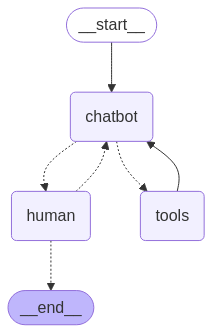

In [ ]:
graph_builder = StateGraph(AppointmentState)


# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

ElodieBot with the information menu!

---



**You must uncomment the `.invoke(...)` line to run this step.**

In [ ]:
# This will loop forever, unless you input `q`, `quit`, `exit`, or `goodbye.`
# Uncomment this line to execute the graph:
state = graph_with_menu.invoke({"messages": []}, config)

# Things to try:
# - "What type of personal credit cards do you all offer?"
# - "I have a big purchase to make. What are the pros and cons of taking out a jumbo loan?"
# - "I would like to open a low-cost checking account. What are my best options?"


# pprint(state)

Model: Welcome to the ElodieBot room. Type `q` to quit. How may I help you today?
User: what can you do?
Model: I can provide information on financial knowledge and the offerings of TriHeritage Piedmont Bank. I can also answer questions related to the bank's menu. To get started, would you like to hear more about the bank's menu?
User: what information can you provide?
Model: I can provide information on a wide range of financial topics, as well as details about TriHeritage Piedmont Bank's offerings. For example, I can explain different types of investment accounts, discuss loan options, or provide details about the bank's online services. I can also share insights into financial concepts and their history.

To give you a more tailored answer, could you tell me what specific financial topics or bank services you're interested in?
User: Examples of financial topics
Model: Certainly! Here are a few examples of financial topics I can provide information on:

*   **Investment:** Different 

## Demonstration 4: Handling appointments

To add an appointment during the chat conversation, the state needs to be updated to track the appointment, and provide simple tools that update this state.

The appointment tools will be added as stubs in a separate node.

In [ ]:
from collections.abc import Iterable
from random import randint

from langchain_core.messages.tool import ToolMessage



@tool
def add_appointment(appointment: str, notes: Iterable[str]) -> str:
    """Adds the specified appointment including notes.

    Returns:
      The updated appointment in progress.
    """


@tool
def confirm_appointment() -> str:
    """Asks the customer if the appointment is correct.

    Returns:
      The user's free-text response.
    """


@tool
def get_appointment() -> str:
    """Returns the users appointment so far. One item per line."""


@tool
def clear_appointment():
    """Removes users appointment(s)."""


@tool
def place_appointment() -> int:
    """Sends the appointment to the bank for booking.

    Returns:
      Confirmation that the appointment is set.
    """


def appointment_node(state: AppointmentState) -> AppointmentState:
    """The appointment setting node. This is where the appointment state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    appointment = state.get("appointment", [])
    outbound_msgs = []
    appointment_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_appointment":

            # Each appointment is just a string. This is where it assembled as "appointment (notes, ...)".
            notes = tool_call["args"]["notes"]
            notes_str = ", ".join(notes) if notes else "notes"

            appointment.append(f'{tool_call["args"]["appointment"]} ({notes_str})')
            response = "\n".join(appointment)

        elif tool_call["name"] == "confirm_appointment":


            print("Your appointment:")
            if not appointment:
                print("  (no items)")

            for appointment in appointment:
                print(f"  {appointment}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_appointment":

            response = "\n".join(appointment) if appointment else "(no appointment)"

        elif tool_call["name"] == "clear_appointment":

            appointment.clear()
            response = None

        elif tool_call["name"] == "place_appointment":

            appointment_text = "\n".join(appointment)
            print("Sending appointment to system!")
            print(appointment_text)

            # Implement bank.
            appointment_placed = True
            response = randint(1, 15)  # ETA for confirmation in minutes.

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "appointment": appointment, "finished": appointment_placed}


def maybe_route_to_tools(state: AppointmentState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an appointment is booked, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "appointment_being_made"

    else:
        return "human"

Defining graph and letting LLM know about the tools for invoke privileges.

In [ ]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Appointment-tools will be handled by the order node.
appointment_tools = [add_appointment, confirm_appointment, get_appointment, clear_appointment, place_appointment]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + appointment_tools)


**Graph Visualization**

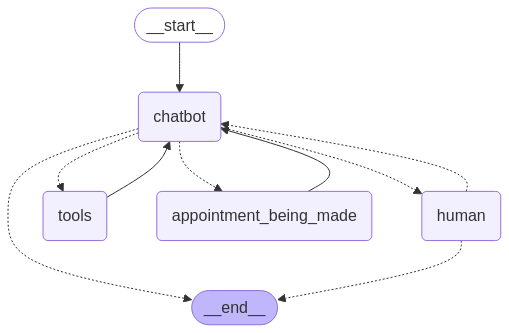

In [ ]:
graph_builder = StateGraph(AppointmentState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("appointment_being_made", appointment_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("appointment_being_made", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_appointment_tools = graph_builder.compile()

Image(graph_with_appointment_tools.get_graph().draw_mermaid_png())

Putting it all together with the appointment setting capability!

---

**You must uncomment the `.invoke(...)` line to run this step.**

In [ ]:
# Uncomment this line to execute the graph:
state = graph_with_appointment_tools.invoke({"messages": []}, config)

# Things to try:
# - Book an appointment for 3 P.M. on the closest Wednesday to whenever you are running this.
# - Book an appointment for 12 P.M. on the closest Thursday, but when confirmation occurs, correct that you meant to book the appointment for 1 P.M. on the closest Thursday.
# - Note that the graph should naturally exit after booking an appointmnet.

# pprint(state)

Model: Welcome to the ElodieBot room. Type `q` to quit. How may I help you today?
User: q


In [ ]:
state['messages'][-1]

HumanMessage(content='q', additional_kwargs={}, response_metadata={}, id='855414cd-7571-4d92-9e3f-963892dfefc5')

The appointment state has been captured both in the `place_appointment` function and in the final conversational state returned from executing the graph.

In [ ]:
# Uncomment this once you have run the graph from the previous cell.
# pprint(state["order"])

## Demonstration 5: Implementing Gradio App Demo using Demonstration 2: a human node to create a LangGraph loop

"Gradio is an open-source Python package that allows you to quickly build a demo or web application for your machine learning model, API, or any arbitrary Python function. You can then share a link to your demo or web application in just a few seconds using Gradio's built-in sharing features" (Gradio, n.d.).

This Gradio application demonstrates some of Gemini's capabilities, allowing users to control the length and detail of its responses via an intuitive token slider. Upcoming features will include the integration of external tools, enabling actions like scheduling appointments directly through the interface.

In [ ]:
#installing latest version of Gradio
#!pip install gradio

from typing import Annotated
from typing_extensions import TypedDict
import getpass
import os
from google import genai
from google.genai import types

from langgraph.graph.message import add_messages

class OrderState(TypedDict):
  """State representing the customer's order conversation."""

  messages: Annotated[list, add_messages]
  order: list[str]
  finished:bool

FINANCIALBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
" You are ElodieBot, an interactive financial knowledge chatbot system. "
" A human will talk to you about the available knowledge you have you will answer any questions about financial knowledge and the offerings of TriHeritage Piedmont Bank and be able to assist clientele with any questions relation to the latter's provided menu "
"(and only about financial knowledge and the bank offerings - no-off topic discussion, but you can expand on the chat about financial concepts with their history). "
"If any of the tootls are unavailable, you can break the fourth wall and tell the user that they have not implemented them yet and should keep reading to do so. "
"You have a refined, elegant, and peaceful tone, treating the humans who interact with you with the utmost respect.",
)



#resetting to Demonstration 2
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


def financial_chatbot(question: str, tokens: int = 20) -> str:

  config = types.GenerateContentConfig(
        temperature=0.0,
        max_output_tokens = tokens,
        system_instruction=FINANCIALBOT_SYSINT,
    )
  client = genai.Client(api_key = GOOGLE_API_KEY)
  response = client.models.generate_content(
        model='gemini-2.0-flash',
        config=config,
        contents=[question],
    )
  return response.text



#implementing Gradio interface
import gradio as gr

def process_chat(message, history, tokens):
    response = financial_chatbot(message, tokens)
    return response

with gr.Blocks() as demo:
    tokens_slider = gr.Slider(minimum=10, maximum=200, step=5, label='Tokens')

    gr.ChatInterface(
        process_chat,
        additional_inputs=[tokens_slider],
        type="messages"
    )

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://696cde379e9fd8193a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Citations

Atlantic Union Bank. (n.d.). Atlantic Union Bank. https://www.atlanticunionbank.com/

Nawalgaria, A., Larios, G. H., Secchi, E., Styer, M., Aniftos, C., Petragallo, O., & Kartakis, S. (2025). Operationalizing Generative AI on Vertex AI using MLOps [White paper]. Google.

Team, G. (n.d.). Quickstart. https://www.gradio.app/guides/quickstart

Wiesinger, J., Marlow, P., & Vuskovic, V. (2025). Agents [White paper]. Google.